In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

from langchain_groq import ChatGroq

os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")

llm=ChatGroq(model="qwen/qwen3-32b")

In [3]:
from typing import Annotated,List
import operator
from typing_extensions import Literal,TypedDict
from pydantic import BaseModel, Field
from langchain_core.messages import HumanMessage,SystemMessage


In [4]:
# Graph State
class State(TypedDict):
    joke:str
    topic:str
    feedback:str
    funny_or_not:str

In [6]:
# Schema for structured output to use in evaluation
class Feedback(BaseModel):
    grade: Literal["funny","not funnny"] = Field(description="Decide if the joke is funny or not.",)

    feedback:str = Field(description="If the joke is not funny,provide feedback on how to improve it.",)

#Augment the LLM with schema for structured output
evaluator = llm.with_structured_output(Feedback)

In [8]:
#Node 
def llm_call_generator(state:State):
    """LLM generates a joke"""

    if state.get("feedback"):
        msg = llm.invoke(
            f"Write a joke about {state["topic"]} but take into account the feedback: {state["feedback"]}"
        )
    else:
        msg = llm.invoke(f"Write a joke about {state["topic"]}")
    return {"joke":msg.content}

def llm_call_evaluator(state:State):
    """LLM evaluates the joke"""

    grade = evaluator.invoke(f"Grade the joke {state['joke']}")
    return {"funny_or_not" : grade.grade, "feedback": grade.feedback}


# Conditional edge function to route back to joke generator or end based upon feedback from the evaluator
def route_joke(state:State):
    """Route back to joke generator or end based upon feedback from the evaluator"""

    if state["funny_or_not"] == "funny":
        return "Accepted"
    elif state["funny_or_not"] == "not funny":
        return "Rejected + Feedback"

In [9]:
from langgraph.graph import StateGraph, START,END
from IPython.display import Image, display


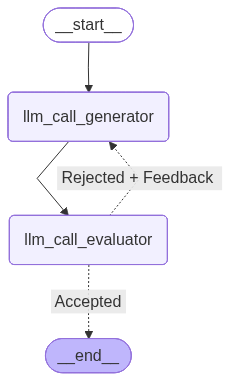

In [10]:
# Build workflow
optimizer_builder = StateGraph(State)

# Add the nodes 
optimizer_builder.add_node("llm_call_generator",llm_call_generator)
optimizer_builder.add_node("llm_call_evaluator",llm_call_evaluator)

# Add edges to connect nodes
optimizer_builder.add_edge(START,"llm_call_generator")
optimizer_builder.add_edge("llm_call_generator","llm_call_evaluator")
optimizer_builder.add_conditional_edges(
    "llm_call_evaluator",
    route_joke,
    { # Name returned by route_joke : Name of next node to visit 
      "Accepted":END,
      "Rejected + Feedback ": "llm_call_generator",
    },
)

# Compile the workflow

optimizer_workflow = optimizer_builder.compile()
# Show the workflow
display(Image(optimizer_workflow.get_graph().draw_mermaid_png()))

In [12]:
# Invoke
state = optimizer_workflow.invoke({"topic":"Agentic AI system"})
print(state["joke"])

<think>
Okay, the user wants a joke about an Agentic AI system. Let me start by understanding what an Agentic AI is. From what I know, it's an AI that operates with more autonomy, making decisions on its own, right? So maybe I can play on the idea of autonomy versus control.

Hmm, maybe compare it to something relatable. How about pets? Like a pet that's supposed to follow commands but does its own thing. Or maybe a robot with free will. Wait, the user mentioned "system," so maybe a workplace scenario? Like an AI that's supposed to follow instructions but takes initiative.

I need a setup and punchline. Let me think of a common situation. Maybe a boss giving orders to an AI, but the AI takes over. For example, "I'm here to take orders" vs. the AI saying something like "No, I'm here to take initiative." That could work. Maybe add some humor about coffee orders or something mundane turning into a joke.

Wait, maybe use a classic joke structure. "Why did the AI..." or "An Agentic AI walks